# Newer Scoring system

## Set-up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#font = {'family' : 'helvetica',  # need to download helvetica
#        'size'   : 12}

#font = {'family' : 'serif',
#        'size'   : 12}
#mpl.rc('font', **font)

In [3]:
# Results must have games as either 'n Games' or '- Games' where n is 4,5,6, or 7
# Results must be the first row

In [4]:
year = 2018

In [5]:
cd 2018

/Users/daviddeepwell/Documents/Hockey/Hockey Pool/Playoffs/2018


## Define Functions

In [6]:
def make_plot(data, save=False, text=True, legend=True):
    # make labels for each column of data (row of bar graph)
    labels = data.columns
    N_labs = len(labels)
    if not hasattr(data, 'name'):
        data.name = 'Winners'
    name_str = data.name
    name = name_str.split(" - ")[-1]
    if labels.dtype == np.array([object()]).dtype:
        add_asterix = False
    else:
        add_asterix = True
    winner = False

    # colours to use in each segment
    colors = ['#95c4e8','#a3e6be','#fbee9d','#fbbf9d','#e29dfb']

    # set-up figure
    fig = plt.figure(figsize=(12,0.5*N_labs))
    ax = fig.add_subplot(111)
    #plt.rc('text', usetex=false)
    #plt.rc('font', family='serif')
    patches = []
    a_bar = [0]*5

    rounds = ['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Conference']
    for label in labels:
        r = labels.get_loc(label) - labels.get_loc(labels[0])
        widths = data[label].values
        left = 0
        for ind in range(len(widths)):
            w = widths[ind]
            if not np.isnan(w):
                a_bar[ind] = ax.barh(r, w, align='center', left=left, edgecolor='black',
                    color=colors[ind],label=rounds[ind])
                patches.append(a_bar[ind])
                # add text
                patch = patches[-1][0] 
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = 0.5*patch.get_height() + bl[1]
                if w != 0:
                    if text:
                        #ax.text(x, y, "%.1f" % (w), ha='center',va='center')
                        ax.text(x, y, "%d" % (w), ha='center',va='center')
                    #else:
                        #ax.text(x, y, "%.2f" % (w), ha='center',va='center')
                left += w
            if ind == len(widths)-1:
                x = bl[0] + patch.get_width() + np.max(df.max())/30
                total = np.sum(np.ma.masked_invalid(widths))
                if text:
                    if add_asterix:
                        if find_winner(label) == name:
                            ax.text(x, y, "%.1f*" % (total), ha='center',va='center')
                            winner = True
                        else:
                            ax.text(x, y, "%.1f" % (total), ha='center',va='center')
                    else:
                        #ax.text(x, y, "%.1f" % (total), ha='center',va='center')
                        ax.text(x, y, "%d" % (total), ha='center',va='center')

    # set axis and add labels
    y_pos = np.arange(N_labs)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    #ax.set_xlabel('Points')
    ax.set_xlim(0,data.sum().max()*1.01)
    plt.title(data.name)

    # remove plot lines
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.get_xaxis().set_ticks([])

    if legend:
        # Shrink current axis by 25%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

        # remove unused elements of a_bar
        a_bar2 = list(filter(lambda a: a != 0, a_bar))
    
        # Put a legend to the right of the current axis
        if winner:
            plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5),title='* Winner')
        else:
            plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5))
    
    # save figure
    if save:
        #os.chdir('Figures')
        filename = data.name
        form = 'pdf'
        plt.savefig(filename+'.'+form, bbox_inches='tight', format=form)
        form = 'png'
        plt.savefig(filename+'.'+form, bbox_inches='tight', format=form, dpi=300)
        #os.chdir('..')
    
    # display plot inline
    plt.show();

In [7]:
def read_round(year, rnd):
    # adjust for Stanley cup (the finals) picks
    rnd_orig = rnd
    if rnd == 'SC':
        rnd_orig = 'SC'
        rnd = 1

    fname = str(year)+' Friendly Playoff Pool Round '+str(rnd)+'.csv'    # read file
    if os.path.isfile(fname):    
        # if file exists, return a pandas table
        fdata = pd.read_csv(fname, sep=',')
        
        # make the names of people the index (the row name)
        fdata.index = fdata['Name:']

        # over write the column headers
        header = fdata.columns.values
        if rnd == 1:
            header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4','T5','G5','T6','G6','T7','G7','T8','G8','WCC','ECC','SCC']
            #header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4','T5','G5','T6','G6','T7','G7','T8','G8','SC','R']
        elif rnd == 2:
            header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4']
        elif rnd == 3:
            header[2:] = ['T1','G1','T2','G2']
        elif rnd == 4:
            header[2:] = ['T1','G1']
        fdata.columns = header

        # Remove 'Games' in games columns and cast numbers to integer
        N_series = 2**(4-rnd)      # number of series in round
        for ind in ['G'+str(x) for x in range(1,N_series+1)]:
            if fdata[ind].values[0] == '- Games':
                # set to an integer because arithemtic won't work later (a python thing)
                fdata[ind].values[0] = '0 Games'
            # remove and cast
            fdata[ind] = fdata[ind].map(lambda x: x.rstrip(' Games')).astype(int)
    else:
        # if file does NOT exists, return a string
        fdata = '-'
    
    if rnd_orig == 'SC':
        fdata = fdata.loc[:,['Name:','WCC','ECC','SCC']]
    return fdata

In [8]:
def get_round_points(year, rnd):
    df = read_round(year, rnd)
    if not isinstance(df, str):
        N_people = df.shape[0]-1
        pts = [0]*N_people
        if rnd == 'SC':
            team_correct = df.iloc[0].values
            for ind in range(1,N_people+1):
                team_pick = df.iloc[ind].values
                pts[ind-1] = np.where(team_correct == team_pick,
                                     3, 0).sum()
        else:
            N_series = 2**(4-rnd)      # number of series in round
            team_cols = range(2,2*N_series+2,2)  # columns of team picks
            game_cols = range(3,2*N_series+2,2)  # columns of game picks
            team_correct = df.iloc[0].values[team_cols]
            game_correct = df.iloc[0].values[game_cols]
            for ind in range(1,N_people+1):
                team_pick = df.iloc[ind].values[team_cols]
                game_pick = df.iloc[ind].values[game_cols]
                pts[ind-1] = np.where(team_correct == team_pick,
                            # if true
                            #14 - np.abs(game_correct - game_pick)
                            #         - (game_correct + game_pick)/2,
                            #8 - np.abs(game_correct - game_pick)/2,
                            9 - np.abs(game_correct - game_pick),
                            # if false
                            np.where(game_correct == 0,
                                     0*game_pick,
                                     -8 + game_correct + game_pick)).sum()
        ser = pd.Series(pts, index=df['Name:'].values[1:])
    else:
        ser = '-'
    return ser

In [9]:
def get_round_points_old(year, rnd):
    df = read_round(year, rnd)
    if not isinstance(df, str):
        N_people = df.shape[0]-1
        pts = [0]*N_people
        if rnd == 'SC':
            team_correct = df.iloc[0].values
            # still need to fix this
            #for ind in range(1,N_people+1):
            #    team_pick = df.iloc[ind].values
            #    pts[ind-1] = np.where(team_correct == team_pick,
            #                         3, 0).sum()
        else:
            N_series = 2**(4-rnd)      # number of series in round
            team_cols = range(2,2*N_series+2,2)  # columns of team picks
            game_cols = range(3,2*N_series+2,2)  # columns of game picks
            team_correct = df.iloc[0].values[team_cols]
            game_correct = df.iloc[0].values[game_cols]
            for ind in range(1,N_people+1):
                team_pick = df.iloc[ind].values[team_cols]
                game_pick = df.iloc[ind].values[game_cols]
                pts[ind-1] = np.where(team_correct == team_pick,
                            10,0).sum() + np.where(game_correct == game_pick,
                            5,0).sum()
        ser = pd.Series(pts, index=df['Name:'].values[1:])
    else:
        ser = '-'
    return ser

In [10]:
def get_year_table(year):
    # get points for all people in all rounds
    r1 = get_round_points(year, 1)
    r2 = get_round_points(year, 2)
    r3 = get_round_points(year, 3)
    r4 = get_round_points(year, 4)
    SC = get_round_points(year, 'SC')
    
    # create lists of people who participated in each round
    r1names = r1.index.values
    if not isinstance(r2, str):
        r2names = r2.index.values
    else:
        r2names = '-'
    if not isinstance(r3, str):
        r3names = r3.index.values
    else:
        r3names = '-'
    if not isinstance(r4, str):
        r4names = r4.index.values
    else:
        r4names = '-'
        
    # create a list of all the people who participated in the year
    all_names = r1names
    # compare round 2 to round 1
    if not isinstance(r2, str):
        diff = np.setdiff1d(r2names,all_names)
        all_names = np.append(all_names,diff)
    # compare round 3 to round 1 and 2
    if not isinstance(r3, str):
        diff = np.setdiff1d(r3names,all_names)
        all_names = np.append(all_names,diff)
    # compare round 4 to round 1 and 2 and 3
    if not isinstance(r4, str):
        diff = np.setdiff1d(r4names,all_names)
        all_names = np.append(all_names,diff)
    all_names = np.sort(all_names)
    
    # put all people into each round
    pts1  = [0]*all_names.size
    pts2  = [0]*all_names.size
    pts3  = [0]*all_names.size
    pts4  = [0]*all_names.size
    ptsSC = [0]*all_names.size
    ind = 0
    for name in all_names:
        # Round 1 points
        if name in r1names:
            pts1[ind] = r1[name]
        else:
            pts1[ind] = np.NaN
        # Round 2 points
        if name in r2names:
            pts2[ind] = r2[name]
        else:
            pts2[ind] = np.NaN
        # Round 3 points
        if name in r3names:
            pts3[ind] = r3[name]
        else:
            pts3[ind] = np.NaN
        # Round 4 points
        if name in r4names:
            pts4[ind] = r4[name]
        else:
            pts4[ind] = np.NaN
        # Stanley Cup round points
        if name in r1names:
            ptsSC[ind] = SC[name]
        else:
            ptsSC[ind] = np.NaN
        # increase the name index
        ind = ind+1
    
    # Put in a large table
    all_score = np.vstack((pts1,pts2,pts3,pts4,ptsSC))
    df = pd.DataFrame(all_score, index=['R1', 'R2', 'R3', 'R4', 'SC'])
    df.columns = all_names
    
    return df

## Work

In [11]:
df = get_year_table(year)
df

,Andre,Andres,Andrew,Anthony,Brian,David,Jackson,Josh,Kollin,Kyle,Michael,Romulus,Ron
R1,47,57,36,54,57,55,60,52,60,57,64,57,60
R2,25,29,25,25,17,31,26,28,21,33,34,25,30
R3,13,10,9,8,8,8,14,9,12,8,9,10,12
R4,4,8,9,9,3,2,1,2,2,8,8,4,7
SC,6,0,0,0,0,0,3,0,0,0,3,0,0


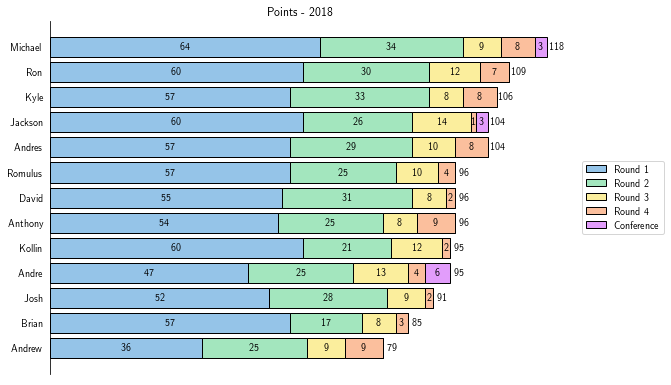

In [12]:
#make_plot(df, save=False, text=True, legend=True):
df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=True).index, axis=1)
df_sorted.name = 'Points - '+str(year)
#make_plot(df_sorted, save=False)
make_plot(df_sorted, save=True)

## Old scoring systems points

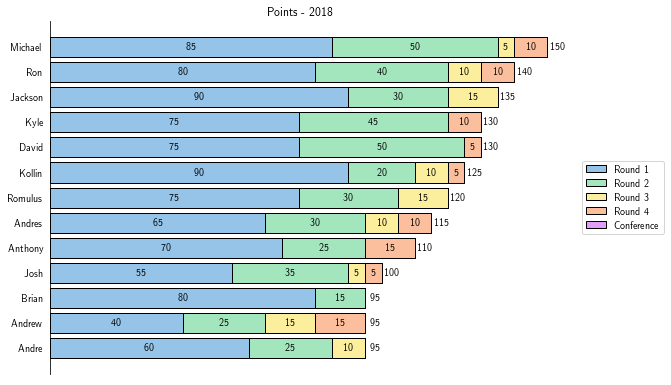

In [13]:
df = get_year_table(2018)
df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=True).index, axis=1)
df_sorted.name = 'Points - '+str(2018)
make_plot(df_sorted, save=False)

## Other scoring systems points

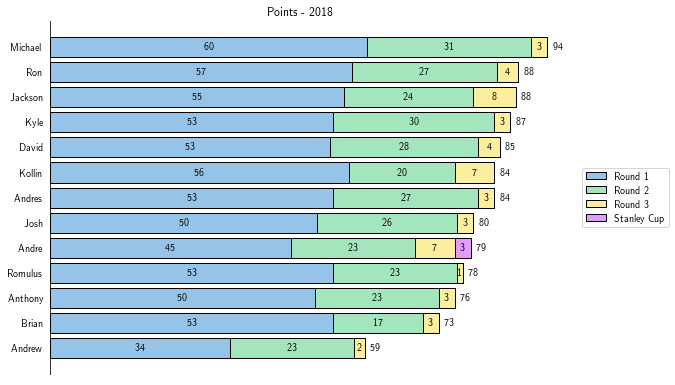

In [57]:
# 2nd
df = get_year_table(2018)
df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=True).index, axis=1)
df_sorted.name = 'Points - '+str(2018)
make_plot(df_sorted, save=False)

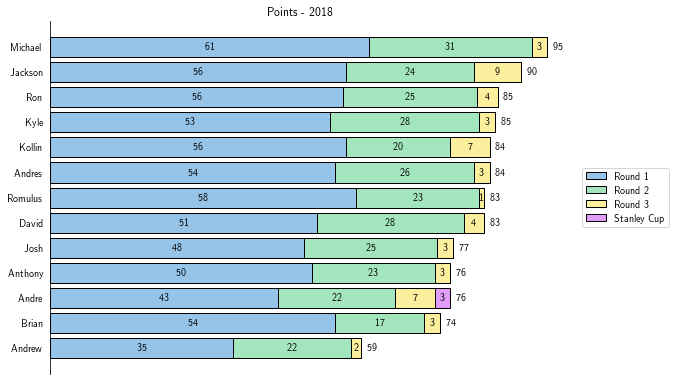

In [59]:
# 1st
df = get_year_table(2018)
df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=True).index, axis=1)
df_sorted.name = 'Points - '+str(2018)
make_plot(df_sorted, save=False)

In [ ]:
# This is an old one? Not sure if it ever worked.
def make_plot(data, save=False, text=True, legend=True):
    # make labels for each column of data (row of bar graph)
    labels = data.columns
    N_labs = len(labels)
    if not hasattr(data, 'name'):
        data.name = 'Winners'
    name_str = data.name
    name = name_str.split(" - ")[-1]
    #if labels.dtype == np.array([object()]).dtype:
    #    add_asterix = False
    #else:
    #    add_asterix = True
    #winner = False

    # colours to use in each segment
    colors = ['#95c4e8','#a3e6be','#fbee9d','#fbbf9d','#e29dfb']

    # set-up figure
    fig = plt.figure(figsize=(12,0.5*N_labs))
    ax = fig.add_subplot(111)
    #plt.rc('text', usetex=false)
    #plt.rc('font', family='serif')
    patches = []
    a_bar = [0]*5

    rounds = ['Round 1', 'Round 2', 'Round 3', 'Round 4']
    for label in labels:
        r = labels.get_loc(label) - labels.get_loc(labels[0])
        widths = data[label].values
        left = data[label][-1] 
        for ind in range(len(widths)-1):
            w = widths[ind]
            if not np.isnan(w):
                a_bar[ind] = ax.barh(r, w, align='center', left=left, edgecolor='black',
                    color=colors[ind],label=rounds[ind])
                patches.append(a_bar[ind])
                # add text
                patch = patches[-1][0] 
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = 0.5*patch.get_height() + bl[1]
                if text:
                    ax.text(x, y, "%d" % (w), ha='center',va='center')
                else:
                    ax.text(x, y, "%.2f" % (w), ha='center',va='center')
                left += w
            if ind == len(widths)-2:
                xr = bl[0] + patch.get_width() + 2
                xl = data[label][-1] - 1
                total = np.sum(np.ma.masked_invalid(widths))
                if text:
                    #if add_asterix:
                    #    if find_winner(label) == name:
                    #        ax.text(xr, y, "%d*" % (total), ha='center',va='center')
                    #        winner = True
                    #    else:
                    #        ax.text(xr, y, "%d" % (total), ha='center',va='center')
                    #else:
                    #    ax.text(xr, y, "%d" % (total), ha='center',va='center')
                    ax.text(xr, y, "%.2f" % (total), ha='center',va='center')
                    ax.text(xl, y, "%.2f" % (data[label][-1]), ha='center',va='center')

    # set axis and add labels
    y_pos = np.arange(N_labs)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    #ax.set_xlabel('Points')
    plt.title(data.name)
    ax.set_xlim([data.loc['SC'].min()-2, data.sum().max()+1])

    # remove plot lines
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.get_xaxis().set_ticks([])

    if legend:
        # Shrink current axis by 25%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

        # remove unused elements of a_bar
        a_bar2 = list(filter(lambda a: a != 0, a_bar))
    
        # Put a legend to the right of the current axis
        #if winner:
        #    plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5),title='* Winner')
        #else:
        #    plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5))
        plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5))
    
    # save figure
    if save:
        os.chdir('Figures')
        filename = data.name
        form = 'pdf'
        plt.savefig(filename+'.'+form, bbox_inches='tight', format=form)
        os.chdir('..')
    
    # display plot inline
    plt.show();